In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['Tahoma']
plt.style.use('seaborn-white')  # 'seaborn-ticks'
import dateutil

In [190]:
animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

# rename columns to remove '_RBG', '_FBG' for element-wise subtraction
rn.columns = rn.columns.str[:-4]
fn.columns = fn.columns.str[:-4]
ri.columns = ri.columns.str[:-4]
fi.columns = fi.columns.str[:-4]
rd.columns = rd.columns.str[:-4]
fd.columns = fd.columns.str[:-4]

qval_sampling = data['fdr corrected pval effect of sampling']
# qval_sampling.replace(np.nan, 1, inplace=True)  # For replacing blanks (model failed to converge) with 1
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

## Make volcano plots that compare random vs fasted for each of normal/impaired/diabetic

In [206]:
def make_volcano_df(df1, df2, qvals):
    v = pd.DataFrame(df1.mean(axis=1) - df2.mean(axis=1), columns=['log2fc']).join(qvals)
    v['log10q'] = -1 * np.log10(v[qvals.name])
    v['type'] = v.index.map(lambda x: 'Metabolite' if x[0] == 'm' else 'Lipid')
    v['signif'] = (v[qvals.name] < 0.05)
    return v

vn_s = make_volcano_df(rn, fn, qval_sampling)
vi_s = make_volcano_df(ri, fi, qval_sampling)
vd_s = make_volcano_df(rd, fd, qval_sampling)
vall_s = make_volcano_df(r, f, qval_sampling)

vn_gt = make_volcano_df(rn, fn, qval_gtol)
vi_gt = make_volcano_df(ri, fi, qval_gtol)
vd_gt = make_volcano_df(rd, fd, qval_gtol)
vall_gt = make_volcano_df(r, f, qval_gtol)

vn_cr = make_volcano_df(rn, fn, qval_cross)
vi_cr = make_volcano_df(ri, fi, qval_cross)
vd_cr = make_volcano_df(rd, fd, qval_cross)
vall_cr = make_volcano_df(r, f, qval_cross)

In [198]:
cmap = sns.color_palette('Set2', 2)
cmap

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)]

In [246]:
def make_volcano(df, include_annotations=True):
    plt.plot([-20, 20], [1.301, 1.301], '--', color='gray')
    # Plot significant values
    sns.scatterplot(data=df[df['signif']], x='log2fc', y='log10q', 
                    hue='type', palette=cmap,
#                     style='type' , markers=['s', '^']
                    alpha=0.7)
    # Plot non-significant
    sns.scatterplot(data=df[df['signif']==False], x='log2fc', y='log10q', color='gray', alpha=0.4)

    # plt.plot([0, 0], [-100, 100], '-', color='gray')
    plt.grid(alpha=0.5)

    fig = plt.gcf()
    fig.set_size_inches((12, 9))

    plt.xlim((-5.8, 5.8))
    plt.ylim(0)
    plt.xlabel('log$_{2}$ fold change', fontsize=16)
    plt.xticks(fontsize=15)
    plt.ylabel('-log$_{10}$(q-value)', fontsize=16)
    plt.yticks(fontsize=14)

    plt.legend(fontsize=17, loc=(1.02, 0.5), markerscale=2)
    if include_annotations:
        plt.annotate('higher in random-fed', xy=(5.5, 2), ha='right', fontsize=15)
        plt.annotate('higher in fasted', xy=(-5.5, 2), ha='left', fontsize=15)

Text(0.5, 1.0, 'Random vs Fasted\nall rats\nq-value = effect of sampling')

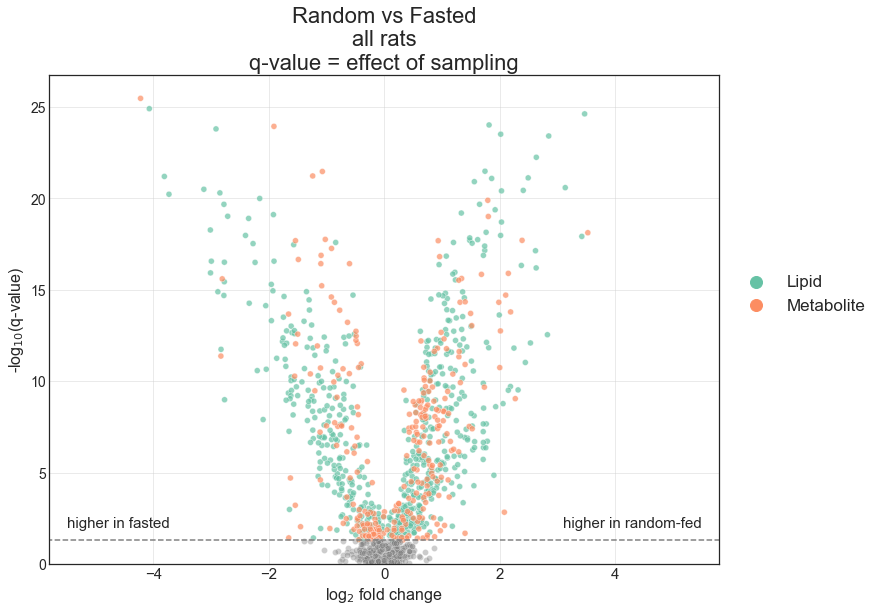

In [247]:
make_volcano(vall_s)
plt.title('Random vs Fasted\nall rats\nq-value = effect of sampling', fontsize=22)

In [221]:
# Using p-values from glucose tolerance makes for a very sad volcano plot when comparing R vs F

# make_volcano(vall_gt)
# plt.title('Random vs Fasted\nall rats\nq-value = effect of glucose tolerance', fontsize=22)

In [222]:
# Using p-values from glucose tolerance makes for a very sad volcano plot when comparing R vs F

# make_volcano(vall_cr)
# plt.title('Random vs Fasted\nall rats\nq-value = effect of interaction', fontsize=22)

Text(0.5, 1.0, 'Random vs Fasted \nNormal glucose tolerance rats')

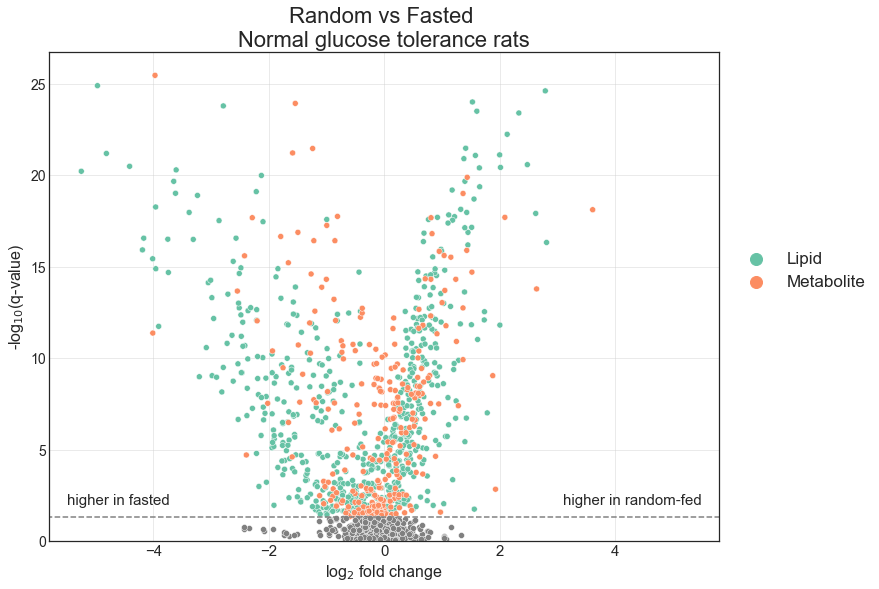

In [223]:
make_volcano(vn)
plt.title('Random vs Fasted \nNormal glucose tolerance rats', fontsize=22)

Text(0.5, 1.0, 'Random vs Fasted \nImpaired glucose tolerance rats')

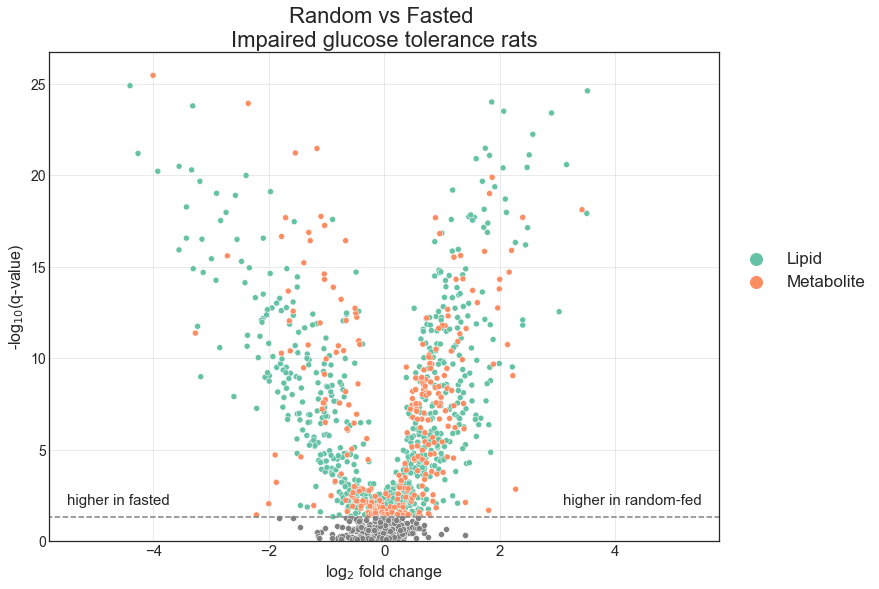

In [224]:
make_volcano(vi)
plt.title('Random vs Fasted \nImpaired glucose tolerance rats', fontsize=22)

Text(0.5, 1.0, 'Random vs Fasted \nDiabetic glucose tolerance rats')

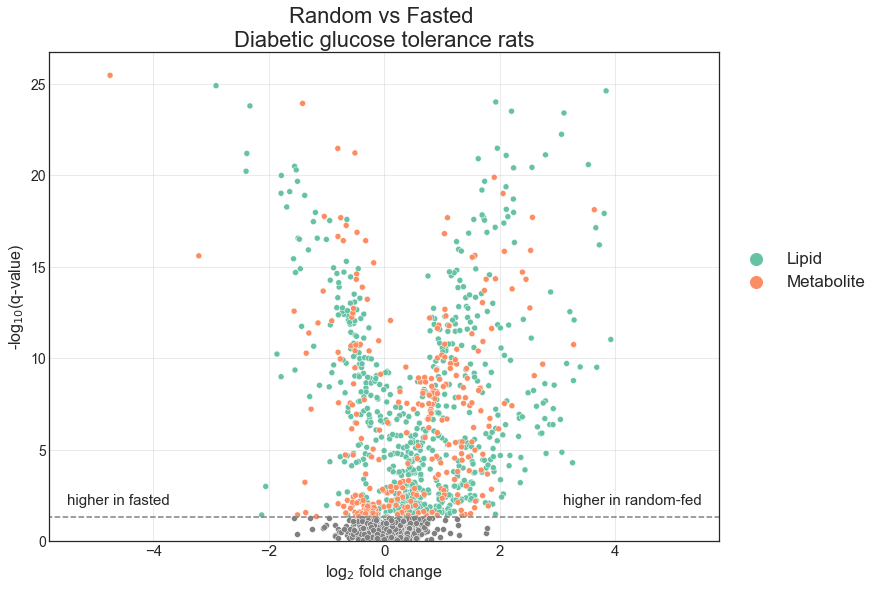

In [225]:
make_volcano(vd)
plt.title('Random vs Fasted \nDiabetic glucose tolerance rats', fontsize=22)

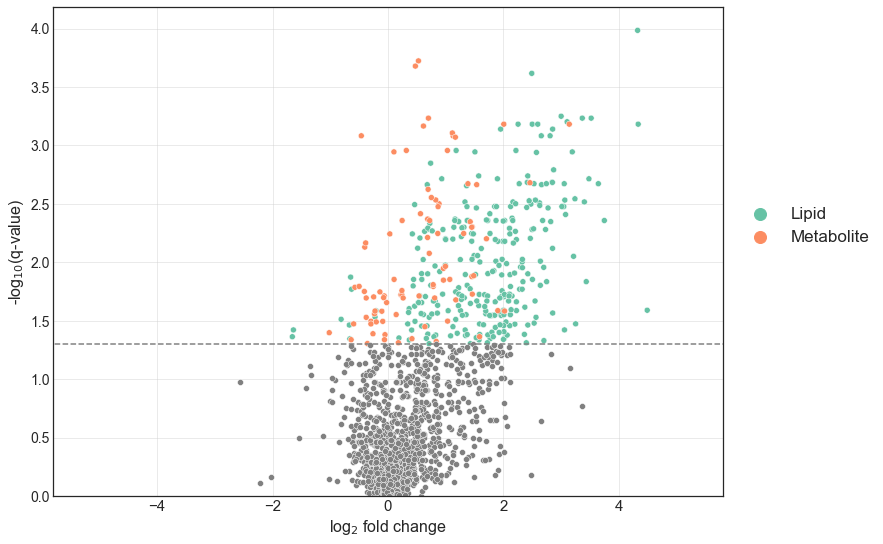

In [238]:
random_n_vs_d = make_volcano_df(rd, rn, qvals=qval_gtol)
make_volcano(random_n_vs_d, include_annotations=False)

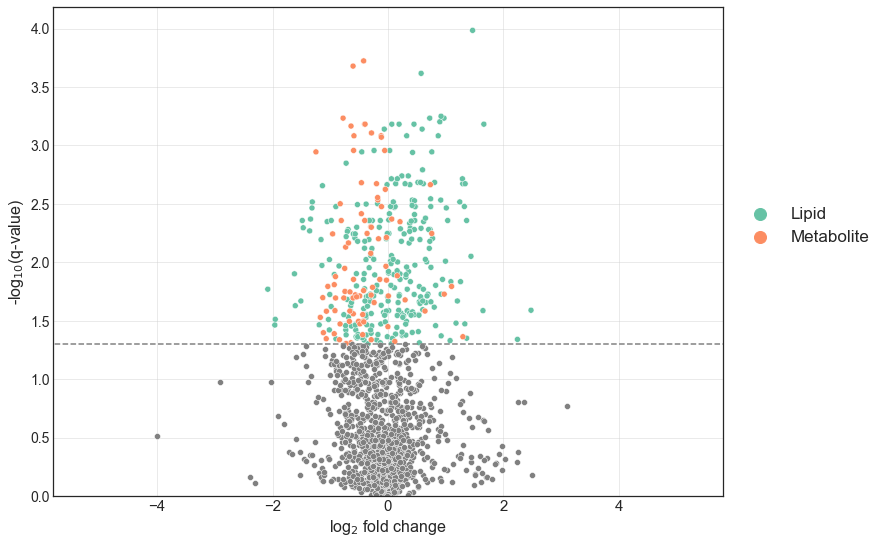

In [239]:
fasted_n_vs_d = make_volcano_df(fd, fn, qvals=qval_gtol)
make_volcano(fasted_n_vs_d, include_annotations=False)

In [231]:
rd

,1101_10,1076_8,1082_10,1076_9,1082_9,1076_10,1101_9,1082_8,1101_8
i,,,,,,,,,
l_0,23.945171,23.534959,23.401962,23.541712,23.689374,24.127917,23.108874,23.360916,23.527438
l_1,25.059545,24.548641,24.532854,23.748730,24.922720,24.837154,24.520275,23.700392,24.558075
l_2,23.771498,24.731989,24.304747,24.149528,24.265127,24.467842,23.499399,22.549975,23.886203
l_3,27.946889,27.298562,27.554509,26.518482,27.350461,27.435902,27.136127,26.194952,26.970428
l_4,22.523599,23.275046,23.251399,22.992578,23.141314,23.446942,22.766840,21.905509,22.823820
...,...,...,...,...,...,...,...,...,...
m_169,25.107260,24.539417,25.097009,24.814954,24.847221,24.595806,24.971366,24.895636,25.168366
m_213,19.516898,20.906036,19.893394,22.548083,22.386925,22.841409,23.117466,23.047250,22.538237
m_24,26.920468,27.407384,27.063199,27.753992,27.590262,27.774313,27.592736,27.782425,27.463850


In [232]:
fd

,1076_10,1082_10,1101_9,1076_9,1082_9,1101_10,1101_8,1082_8,1076_8
i,,,,,,,,,
l_0,20.405355,23.387975,23.463756,24.094632,23.603628,22.354988,23.645107,23.304379,23.539082
l_1,21.533648,24.696276,24.934805,25.459699,24.931622,24.278683,24.653076,24.836832,23.788721
l_2,20.665848,24.085858,24.010849,24.438818,23.931040,23.424566,23.751732,24.099594,24.205352
l_3,24.400930,27.230430,27.126653,27.419317,27.281467,26.636591,26.803373,26.654377,26.910925
l_4,19.378685,22.878785,22.703282,22.724492,21.892055,22.309808,23.065242,22.329975,22.171034
...,...,...,...,...,...,...,...,...,...
m_169,24.882649,24.852314,24.826840,24.438844,24.671492,25.334798,24.784965,24.813900,24.745531
m_213,20.930852,22.052052,19.078979,17.747657,18.605718,21.860700,16.824885,20.710067,22.252718
m_24,27.101820,27.438797,26.924145,26.167222,26.545930,27.389479,26.062803,27.132299,27.498867


In [234]:
rd - fd

,1076_10,1076_8,1076_9,1082_10,1082_8,1082_9,1101_10,1101_8,1101_9
i,,,,,,,,,
l_0,3.722562,-0.004123,-0.552920,0.013987,0.056538,0.085746,1.590183,-0.117669,-0.354883
l_1,3.303506,0.759920,-1.710969,-0.163422,-1.136440,-0.008902,0.780862,-0.095000,-0.414530
l_2,3.801993,0.526637,-0.289290,0.218890,-1.549619,0.334087,0.346933,0.134471,-0.511450
l_3,3.034973,0.387636,-0.900835,0.324078,-0.459425,0.068995,1.310297,0.167055,0.009474
l_4,4.068257,1.104012,0.268086,0.372613,-0.424465,1.249259,0.213791,-0.241422,0.063558
...,...,...,...,...,...,...,...,...,...
m_169,-0.286843,-0.206114,0.376110,0.244695,0.081736,0.175729,-0.227537,0.383401,0.144526
m_213,1.910557,-1.346682,4.800427,-2.158658,2.337183,3.781206,-2.343802,5.713352,4.038487
m_24,0.672493,-0.091483,1.586770,-0.375597,0.650125,1.044332,-0.469011,1.401047,0.668590
